# Import Libraries and Data

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn

In [57]:
medical = pd.read_csv('../../data/raw/02_medical_records.csv')

# Data Exploratory
### Overall Understanding
- dataset is generally quite balanced, further balancing not required
- no duplicates or nulls in dataset
- holds categorical values that needs to be one hot encoded
- no multicollinearity issue
- anomaly present in resting_BP
- values come in large range, normalisation required to convert to common scale

In [58]:
print(medical.shape)
medical.head()

(918, 12)


,age,gender,chest_pain,resting_BP,cholesterol,fasting_BS,resting_ECG,max_HR,exercise_angina,old_peak,ST_slope,cv_issue
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [59]:
medical.describe()

,age,resting_BP,cholesterol,fasting_BS,max_HR,old_peak,cv_issue
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [60]:
medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              918 non-null    int64  
 1   gender           918 non-null    object 
 2   chest_pain       918 non-null    object 
 3   resting_BP       918 non-null    int64  
 4   cholesterol      918 non-null    int64  
 5   fasting_BS       918 non-null    int64  
 6   resting_ECG      918 non-null    object 
 7   max_HR           918 non-null    int64  
 8   exercise_angina  918 non-null    object 
 9   old_peak         918 non-null    float64
 10  ST_slope         918 non-null    object 
 11  cv_issue         918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Check Duplicates and Nulls 
- Dataset does not hold any duplicates or nulls

In [61]:
medical.duplicated().sum()

0

In [62]:
medical.isna().sum()

age                0
gender             0
chest_pain         0
resting_BP         0
cholesterol        0
fasting_BS         0
resting_ECG        0
max_HR             0
exercise_angina    0
old_peak           0
ST_slope           0
cv_issue           0
dtype: int64

## Check Dataset Balanceness
- Generally quite balanced across all

1    508
0    410
Name: cv_issue, dtype: int64


<Axes: ylabel='cv_issue'>

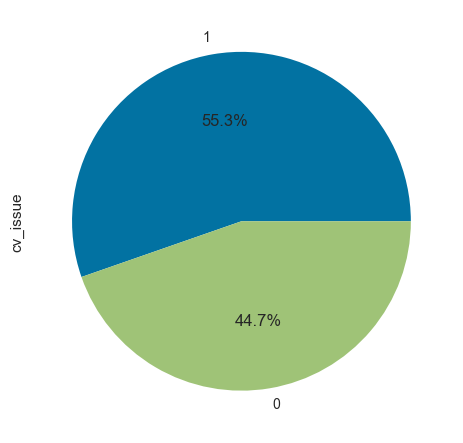

In [63]:
print(medical["cv_issue"].value_counts())
medical["cv_issue"].value_counts().plot(kind='pie', autopct='%1.1f%%')

## Check Distribution of data
- Age and max_HR shows several distinct groups 
    - bin data
- dataset features range across large values 
    - normalize

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'resting_BP'}>,
        <Axes: title={'center': 'cholesterol'}>],
       [<Axes: title={'center': 'fasting_BS'}>,
        <Axes: title={'center': 'max_HR'}>,
        <Axes: title={'center': 'old_peak'}>],
       [<Axes: title={'center': 'cv_issue'}>, <Axes: >, <Axes: >]],
      dtype=object)

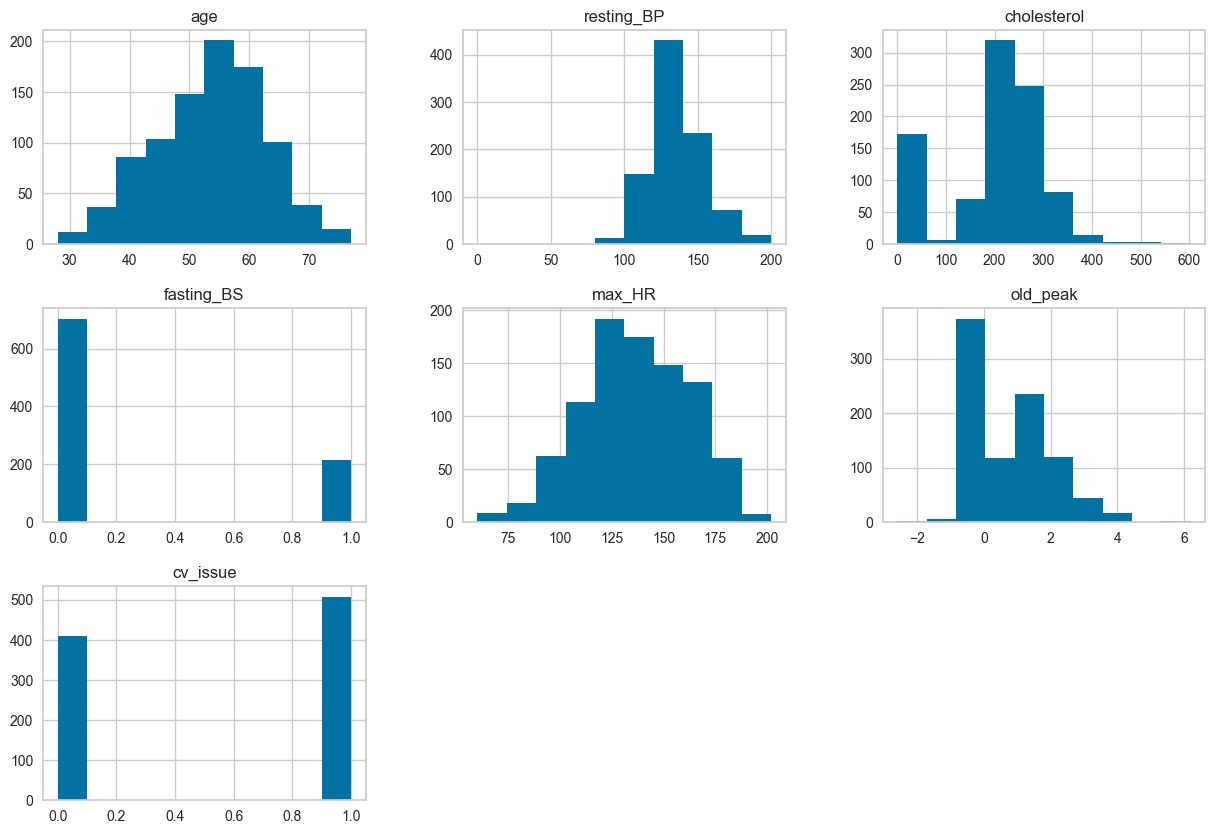

In [64]:
medical.hist(figsize=(15,10))

## Correlation plot 
- no multicollinearity issue seen

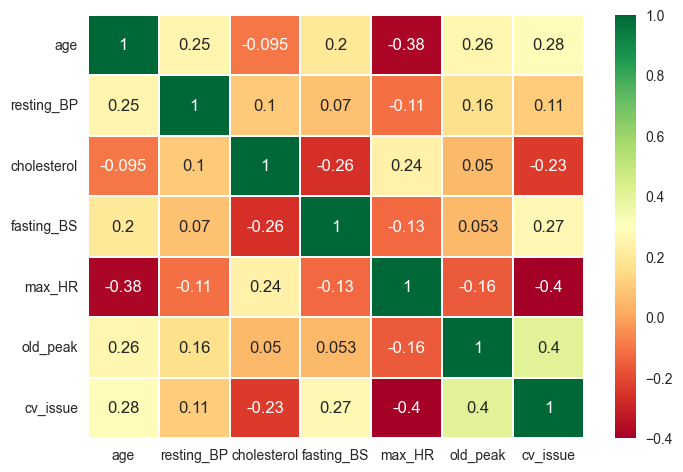

In [65]:
numeric_columns = medical.select_dtypes(include=[np.number])
sns.heatmap(numeric_columns.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

## Scatterplot
- resting_BP holds an outlier of 0

<Axes: xlabel='cv_issue', ylabel='max_HR'>

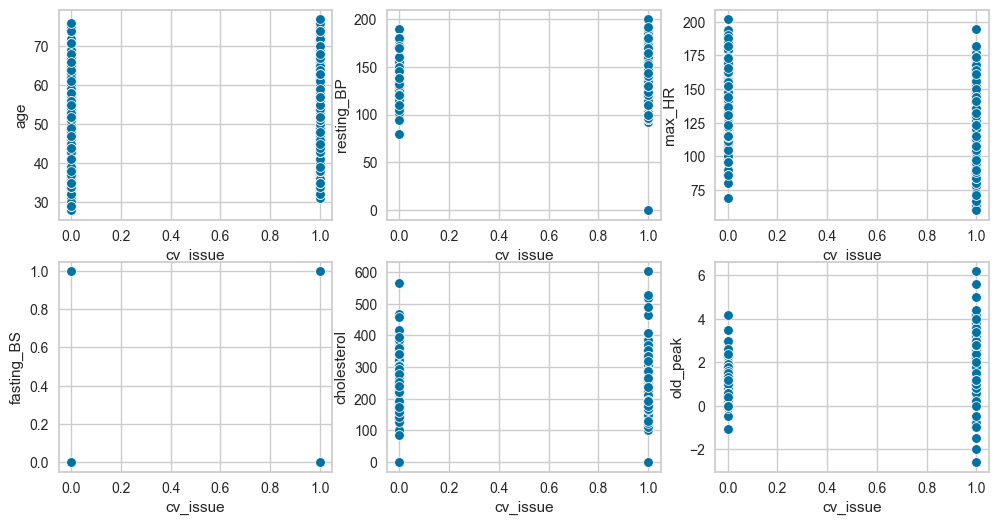

In [66]:
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (12, 6))

sns.scatterplot(x="cv_issue", y="age", data=medical, ax=ax[0][0])
sns.scatterplot(x="cv_issue", y="resting_BP", data=medical, ax=ax[0][1])
sns.scatterplot(x="cv_issue", y="cholesterol", data=medical, ax=ax[1][1])
sns.scatterplot(x="cv_issue", y="fasting_BS", data=medical, ax=ax[1][0])
sns.scatterplot(x="cv_issue", y="old_peak", data=medical, ax=ax[1][2])
sns.scatterplot(x="cv_issue", y="max_HR", data=medical, ax=ax[0][2])


## Further Analysis of Data
- In general, resting_BP is higher as age increases
- More people with older age also have exercise agina
- Flat ST Slope affects cardivascular disease the most while up slope affects cholestrol more

<Axes: xlabel='age', ylabel='resting_BP'>

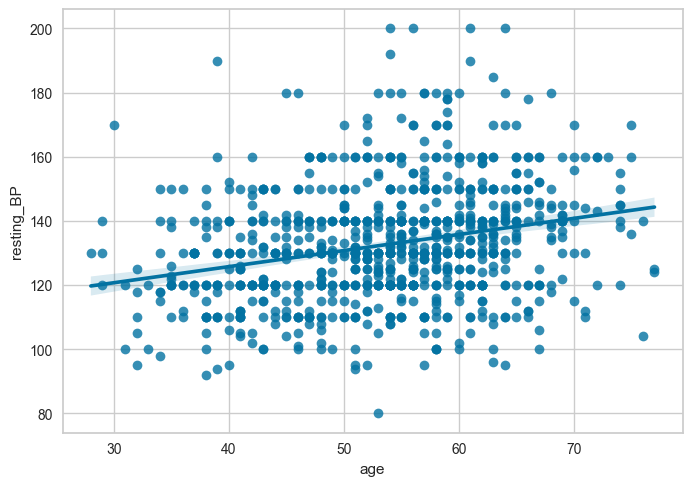

In [90]:
sns.regplot(x='age',y='resting_BP',data=medical)

Text(0.5, 1.0, 'Age distribution by Exercise Induced Angina')

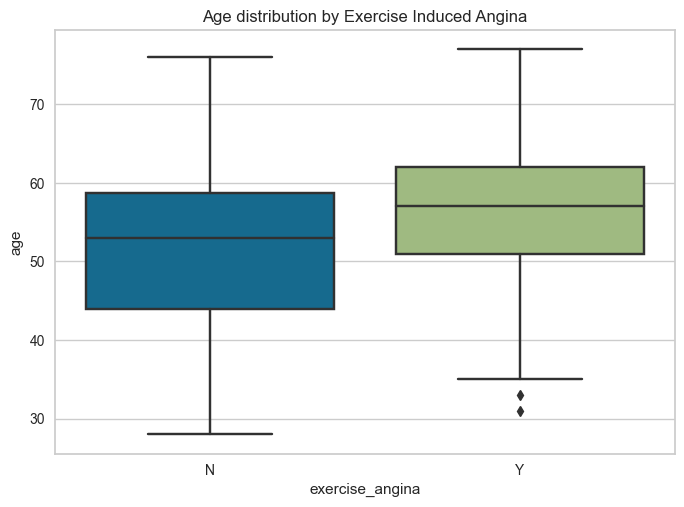

In [92]:
fig, ax = plt.subplots()
sns.boxplot(x='exercise_angina', y='age', data=medical, ax=ax)
ax.set_title('Age distribution by Exercise Induced Angina')

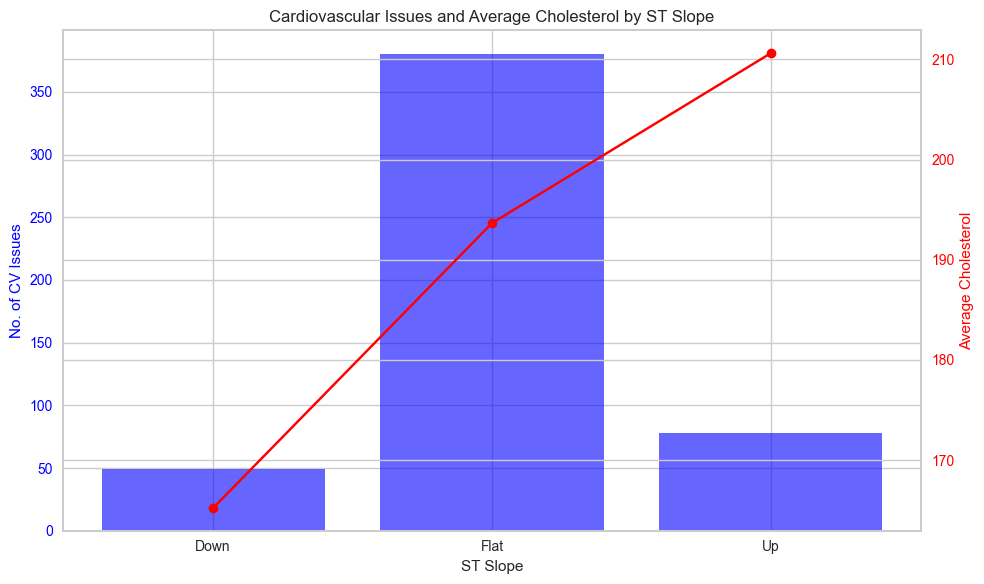

In [94]:
grouped = medical.groupby('ST_slope').agg(cv_issues_count=('cv_issue', lambda x: (x==1).sum()), avg_cholesterol=('cholesterol', 'mean')).reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar plot for frequency of cv issues
ax1.bar(grouped['ST_slope'], grouped['cv_issues_count'], color='blue', alpha=0.6, label='No. of CV Issues')
ax1.set_xlabel('ST Slope')
ax1.set_ylabel('No. of CV Issues', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Line plot for average cholesterol
ax2 = ax1.twinx() # Create a second y-axis
ax2.plot(grouped['ST_slope'], grouped['avg_cholesterol'], color='red', marker='o', label='Avg. Cholesterol')
ax2.set_ylabel('Average Cholesterol', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Show plot
plt.title('Cardiovascular Issues and Average Cholesterol by ST Slope')
fig.tight_layout()

## Understanding Categorical Data 
- categorical data to be converted to numerical w one hot encoding

In [67]:
non_numeric = medical.select_dtypes(include=['object'])
for column in non_numeric.columns:
    print(f"Value counts for column '{column}':\n{non_numeric[column].value_counts()}\n")

Value counts for column 'gender':
M    725
F    193
Name: gender, dtype: int64

Value counts for column 'chest_pain':
ASY    496
NAP    203
ATA    173
TA      46
Name: chest_pain, dtype: int64

Value counts for column 'resting_ECG':
Normal    552
LVH       188
ST        178
Name: resting_ECG, dtype: int64

Value counts for column 'exercise_angina':
N    547
Y    371
Name: exercise_angina, dtype: int64

Value counts for column 'ST_slope':
Flat    460
Up      395
Down     63
Name: ST_slope, dtype: int64



# Data Preparation and Modelling

In [13]:
model = setup(data = medical, target = 'cv_issue', normalize = True, normalize_method='minmax', train_size = 0.8, remove_outliers=True, bin_numeric_features=['age', 'max_HR'],session_id=123, log_experiment=True, experiment_name='medical', fold=10)

,Description,Value
0,Session id,123
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(918, 12)"
4,Transformed data shape,"(881, 19)"
5,Transformed train set shape,"(697, 19)"
6,Transformed test set shape,"(184, 19)"
7,Ordinal features,2
8,Numeric features,6
9,Categorical features,5


2023/08/20 11:03:03 INFO mlflow.tracking.fluent: Experiment with name 'medical' does not exist. Creating a new experiment.


## Ensuring Dataset Cleaned
- From replotted model, can see that though model shape decreased in setup, anomaly was not correctly detected.
- Manually remove anomaly first before new setup

<Axes: xlabel='cv_issue', ylabel='resting_BP'>

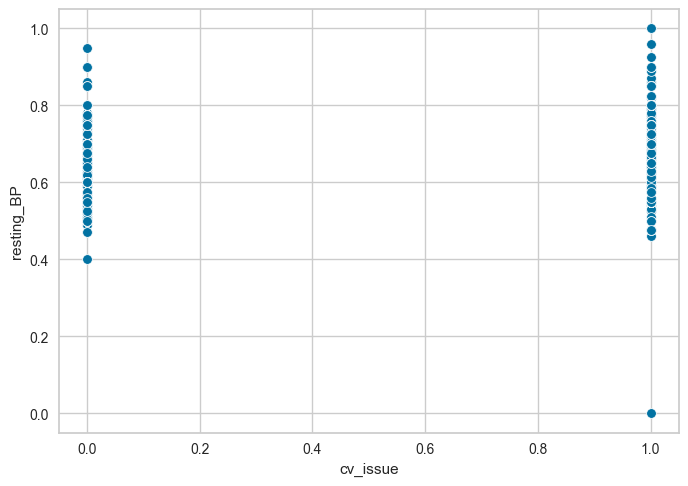

In [14]:
sns.scatterplot(x="cv_issue", y="resting_BP", data=model.dataset_transformed)

## Resetup 
- Previously shown that setup does not remove anomaly
- Remove anomaly and resetup
- Replot new setup 
    - anomaly has been removed

In [68]:
medical = medical[medical['resting_BP'] > 0.2]

In [79]:
model = setup(data = medical, target = 'cv_issue', normalize = True, normalize_method='minmax', train_size = 0.8, remove_outliers=True, bin_numeric_features=['age', 'max_HR'],session_id=123, log_experiment=True, experiment_name='medical', fold=10)

,Description,Value
0,Session id,123
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(917, 12)"
4,Transformed data shape,"(880, 19)"
5,Transformed train set shape,"(696, 19)"
6,Transformed test set shape,"(184, 19)"
7,Ordinal features,2
8,Numeric features,6
9,Categorical features,5


<Axes: xlabel='cv_issue', ylabel='resting_BP'>

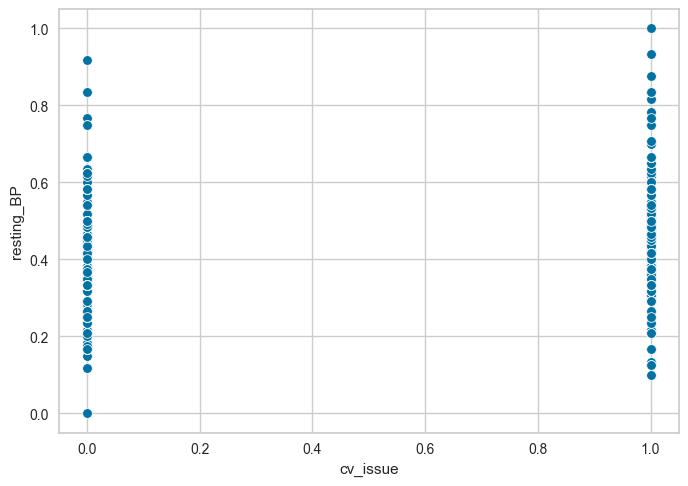

In [80]:
sns.scatterplot(x="cv_issue", y="resting_BP", data=model.dataset_transformed)

## Understanding Setup Features
- Ensure that all features correctly assumed
- Ensure Dataset correctly transformed

In [81]:
#Print ordinal, numeric and categorical features
print(f'Ordinal features: {model._fxs["Ordinal"]}')
print(f'Numeric features: {model._fxs["Numeric"]}')
print(f'Categorical features: {model._fxs["Categorical"]}')

Ordinal features: {'gender': ['F', 'M'], 'exercise_angina': ['N', 'Y']}
Numeric features: ['age', 'resting_BP', 'cholesterol', 'fasting_BS', 'max_HR', 'old_peak']
Categorical features: ['gender', 'chest_pain', 'resting_ECG', 'exercise_angina', 'ST_slope']


In [82]:
model.dataset_transformed

,age,gender,chest_pain_NAP,chest_pain_ASY,chest_pain_ATA,chest_pain_TA,resting_BP,cholesterol,fasting_BS,resting_ECG_Normal,resting_ECG_ST,resting_ECG_LVH,max_HR,exercise_angina,old_peak,ST_slope_Flat,ST_slope_Up,ST_slope_Down,cv_issue
316,0.50,1.0,1.0,0.0,0.0,0.0,0.208333,0.000000,1.0,1.0,0.0,0.0,0.75,0.0,0.353659,1.0,0.0,0.0,1
435,0.75,1.0,0.0,1.0,0.0,0.0,0.600000,0.000000,0.0,0.0,1.0,0.0,0.25,1.0,0.317073,0.0,1.0,0.0,0
904,0.50,1.0,0.0,0.0,1.0,0.0,0.333333,0.398010,0.0,1.0,0.0,0.0,1.00,0.0,0.317073,0.0,0.0,1.0,0
469,0.50,1.0,0.0,0.0,1.0,0.0,0.366667,0.371476,1.0,1.0,0.0,0.0,0.75,0.0,0.560976,1.0,0.0,0.0,0
372,0.75,1.0,0.0,1.0,0.0,0.0,0.875000,0.000000,0.0,1.0,0.0,0.0,0.00,1.0,0.317073,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,0.00,1.0,0.0,1.0,0.0,0.0,0.125000,0.000000,1.0,0.0,1.0,0.0,0.75,0.0,0.317073,0.0,1.0,0.0,1
629,0.50,0.0,0.0,1.0,0.0,0.0,0.400000,0.502488,0.0,0.0,0.0,1.0,0.75,0.0,0.317073,0.0,1.0,0.0,0
810,0.50,0.0,0.0,0.0,1.0,0.0,0.458333,0.414594,0.0,0.0,0.0,1.0,0.75,0.0,0.487805,1.0,0.0,0.0,0
306,0.50,1.0,0.0,1.0,0.0,0.0,0.291667,0.000000,1.0,1.0,0.0,0.0,0.75,0.0,0.329268,1.0,0.0,0.0,1


## Find Best Model 
- Overall best model is et (Extra Trees Classifier)

In [83]:
best = model.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8745,0.9185,0.8990,0.8811,0.8882,0.7446,0.7484,5.3440
rf,Random Forest Classifier,0.8731,0.9284,0.9088,0.8709,0.8883,0.7413,0.7447,5.3840
lightgbm,Light Gradient Boosting Machine,0.8705,0.9285,0.9040,0.8701,0.8851,0.7365,0.7410,5.0290
lda,Linear Discriminant Analysis,0.8664,0.9220,0.9065,0.8608,0.8820,0.7279,0.7319,6.0750
ridge,Ridge Classifier,0.8650,0.0000,0.9040,0.8605,0.8806,0.7252,0.7292,5.3570
gbc,Gradient Boosting Classifier,0.8650,0.9294,0.9015,0.8641,0.8810,0.7248,0.7292,5.3640
lr,Logistic Regression,0.8595,0.9233,0.9013,0.8552,0.8766,0.7135,0.7173,5.0550
knn,K Neighbors Classifier,0.8582,0.8962,0.8892,0.8608,0.8737,0.7118,0.7149,4.7410
svm,SVM - Linear Kernel,0.8487,0.0000,0.8673,0.8631,0.8621,0.6942,0.7001,5.1290
nb,Naive Bayes,0.8486,0.8996,0.8717,0.8599,0.8646,0.6925,0.6949,5.4500


# Feature Selection
- resetup model with feature selection to see if model performs better
- best model performs worse, hence will use model without feature selection

In [76]:
model2 = setup(data = medical, target = 'cv_issue', normalize = True, normalize_method='minmax', train_size = 0.8, remove_outliers=True, bin_numeric_features=['age', 'max_HR'],session_id=123, log_experiment=True, experiment_name='medical', fold=10, feature_selection=True, n_features_to_select=0.8)

,Description,Value
0,Session id,123
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(917, 12)"
4,Transformed data shape,"(880, 9)"
5,Transformed train set shape,"(696, 9)"
6,Transformed test set shape,"(184, 9)"
7,Ordinal features,2
8,Numeric features,6
9,Categorical features,5


based on feature selection, below are the more important features

In [77]:
model2.dataset_transformed

,age,gender,chest_pain_ASY,resting_BP,cholesterol,max_HR,exercise_angina,old_peak,cv_issue
316,0.50,1.0,0.0,0.208333,0.000000,0.75,0.0,0.353659,1
435,0.75,1.0,1.0,0.600000,0.000000,0.25,1.0,0.317073,0
904,0.50,1.0,0.0,0.333333,0.398010,1.00,0.0,0.317073,0
469,0.50,1.0,0.0,0.366667,0.371476,0.75,0.0,0.560976,0
372,0.75,1.0,1.0,0.875000,0.000000,0.00,1.0,0.317073,1
...,...,...,...,...,...,...,...,...,...
333,0.00,1.0,1.0,0.125000,0.000000,0.75,0.0,0.317073,1
629,0.50,0.0,1.0,0.400000,0.502488,0.75,0.0,0.317073,0
810,0.50,0.0,0.0,0.458333,0.414594,0.75,0.0,0.487805,0
306,0.50,1.0,1.0,0.291667,0.000000,0.75,0.0,0.329268,1


model performed worse here as compared to no feature selection 

In [78]:
best_select = model2.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8486,0.9046,0.8815,0.8553,0.8661,0.6914,0.6972,4.6040
qda,Quadratic Discriminant Analysis,0.8431,0.9136,0.8989,0.8358,0.8639,0.6786,0.6878,5.2100
rf,Random Forest Classifier,0.8391,0.9014,0.8766,0.8452,0.8589,0.6711,0.6754,5.7160
ridge,Ridge Classifier,0.8377,0.0000,0.8618,0.8499,0.8549,0.6704,0.6724,4.7590
lda,Linear Discriminant Analysis,0.8377,0.9017,0.8593,0.8517,0.8545,0.6706,0.6726,3.9960
lr,Logistic Regression,0.8350,0.9022,0.8596,0.8468,0.8522,0.6651,0.6670,5.0640
knn,K Neighbors Classifier,0.8254,0.8716,0.8445,0.8449,0.8427,0.6457,0.6499,4.6580
gbc,Gradient Boosting Classifier,0.8213,0.8961,0.8741,0.8196,0.8440,0.6345,0.6408,4.9950
lightgbm,Light Gradient Boosting Machine,0.8213,0.8953,0.8543,0.8312,0.8414,0.6363,0.6390,4.4150
et,Extra Trees Classifier,0.8199,0.8940,0.8446,0.8366,0.8394,0.6338,0.6361,4.0410


# Model Tuning
- From model metrics, output shows that not tuned model performed better, hence will use not tuned best model

In [39]:
best = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8649,0.9176,0.9024,0.8605,0.8810,0.7249,0.7260
1,0.8243,0.8725,0.8537,0.8333,0.8434,0.6434,0.6437
2,0.9189,0.9409,0.9024,0.9487,0.9250,0.8369,0.8381
3,0.8514,0.9242,0.9268,0.8261,0.8736,0.6947,0.7015
4,0.7671,0.8438,0.8537,0.7609,0.8046,0.5188,0.5241
5,0.8493,0.9421,0.8293,0.8947,0.8608,0.6971,0.6995
6,0.8082,0.9019,0.8000,0.8421,0.8205,0.6149,0.6159
7,0.8904,0.9292,0.9250,0.8810,0.9024,0.7776,0.7788
8,0.9178,0.9708,0.9000,0.9474,0.9231,0.8350,0.8362


In [84]:
best.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [85]:
tuned_best = tune_model(best, return_tuner=True) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8784,0.9416,0.9512,0.8478,0.8966,0.7502,0.7575
1,0.8243,0.8581,0.8293,0.8500,0.8395,0.6455,0.6458
2,0.8514,0.9261,0.8537,0.8750,0.8642,0.7001,0.7003
3,0.8767,0.9512,0.9268,0.8636,0.8941,0.7470,0.7497
4,0.7945,0.8460,0.9024,0.7708,0.8315,0.5724,0.5842
5,0.8904,0.9371,0.8750,0.9211,0.8974,0.7800,0.7811
6,0.8767,0.9477,0.9000,0.8780,0.8889,0.7505,0.7508
7,0.8630,0.9379,0.9500,0.8261,0.8837,0.7190,0.7295
8,0.9315,0.9629,0.9500,0.9268,0.9383,0.8614,0.8617


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


# Model Evaluation

In [42]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Predict best model

In [27]:
best_predict = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8696,0.9183,0.8529,0.9062,0.8788,0.7379,0.7395


In [28]:
best_predict.head()

,age,gender,chest_pain,resting_BP,cholesterol,fasting_BS,resting_ECG,max_HR,exercise_angina,old_peak,ST_slope,cv_issue,prediction_label,prediction_score
862,65,F,NAP,155,269,0,Normal,148,N,0.8,Up,0,0,1.00
161,49,M,ASY,128,212,0,Normal,96,Y,0.0,Flat,1,1,0.95
872,55,M,ASY,132,353,0,Normal,132,Y,1.2,Flat,1,1,0.99
47,50,M,ATA,140,216,0,Normal,170,N,0.0,Up,0,0,1.00
300,60,M,ASY,160,0,1,Normal,149,N,0.4,Flat,1,1,0.97


## Save Model Pipeline

In [30]:
final_best = finalize_model(best)
save_model(final_best, 'medical_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\SHERMA~1\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'resting_BP', 'cholesterol',
                                              'fasting_BS', 'max_HR',
                                              'old_peak'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',...
                  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                       class_weight

In [31]:
load_pipeline = load_model('medical_pipeline')
load_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\SHERMA~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'resting_BP', 'cholesterol',
                                             'fasting_BS', 'max_HR',
                                             'old_peak'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='sqrt',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=100, n_jobs=-1,
                                      oob_score=False, random_state=123,
                                      verbose=0, warm_start=False))],
         verbose=False)

# Model Registry

In [50]:
# Calculate evaluation metrics
y_true = best_predict['cv_issue']
y_pred = best_predict['prediction_label']
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
mlflow.end_run()
# Register the pipeline with MLflow
with mlflow.start_run() as run:
    mlflow.log_param('train_size', 0.8)
    mlflow.log_param('transformation', True)
    mlflow.log_param('normalize', True)
    mlflow.log_param('remove_outliers', True)
    mlflow.log_param('bin_numeric_features', ['age', 'max_HR'])
    mlflow.log_param('fold', 5)
    
    # Log metrics
    mlflow.log_metric('MAE', mae)
    mlflow.log_metric('MSE', mse)
    mlflow.log_metric('RMSE', rmse)
    mlflow.log_metric('R2', r2)
    
    # Log the experiment name and run ID
    mlflow.set_experiment('medical_final')
    mlflow.log_param('experiment_name', 'medical_final')
    mlflow.log_param('run_id', run.info.run_id)
    
    # Log the pipeline object using mlflow.sklearn
    mlflow.sklearn.log_model(sk_model=best, registered_model_name='medical_final', artifact_path='sk_model')


Successfully registered model 'medical_final'.
2023/08/20 21:36:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: medical_final, version 1
Created version '1' of model 'medical_final'.
